In [1]:
using PyPlot
include("acoustic_solver.jl")

backward_diff_y (generic function with 1 method)

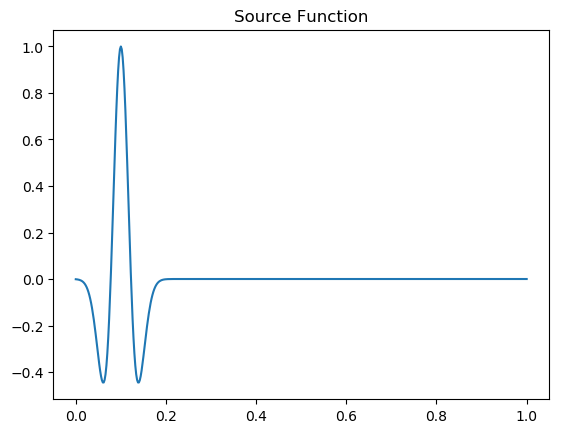

In [173]:
Nx = 51; Ny = 51;
dx = 0.005; dy = dx;

Fs = 500;
dt = 1/Fs;
Nt = 501;
t = range(0, step=dt, length=Nt);

# source_func = sin.(2*pi*20*t);
source_func = source_ricker(10, 0.1, t);
plot(t, source_func); title("Source Function");

In [174]:
source = zeros(Nt,11);
for i = 1:11
    source[:,i] .= source_func;
end
# source[:,1] .=  sin.(2*pi*5*t);

source_position = zeros(Int, 11, 2);
for i = 1:11
    source_position[i,2] = 2
    source_position[i,1] = (i-1)*5+1
#     source_position[i,1] = 50
#     source_position[i,2] = 30
end

# Model 1
receiver_position = zeros(Int,51,2);
for i = 1:51
    receiver_position[i,1] = i
    receiver_position[i,2] = 50;
end
# Model 2
# receiver_position = zeros(Int,1,2);
# for i = 1:1
#     receiver_position[i,2] = 70
#     receiver_position[i,1] = 50
# end

c = 1*ones(Nx, Ny); rho = ones(Nx,Ny);
a0 = 1 ./ (c.^2 .* rho);
b0 = 1 ./ rho;

c[20:30,20:30] .= 1.2;

a = 1 ./ (c.^2 .* rho);
b = 1 ./ rho;
using ImageFiltering
a0 = imfilter(a, Kernel.gaussian(30));
b0 = imfilter(b, Kernel.gaussian(30));

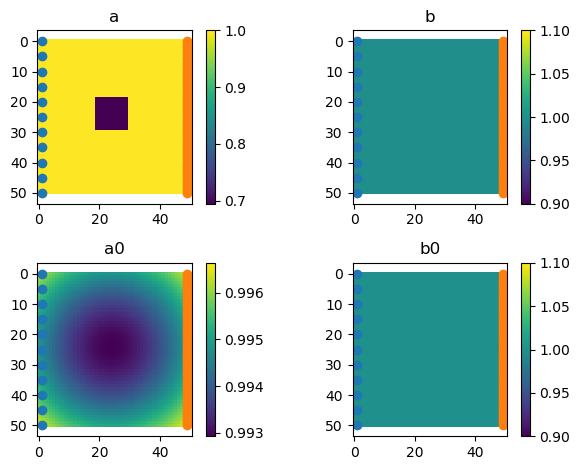

In [175]:
subplot(221)
imshow(a); colorbar(); title("a")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

subplot(222)
imshow(b); colorbar(); title("b")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

subplot(223)
imshow(a0); colorbar(); title("a0")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

subplot(224)
imshow(b0); colorbar(); title("b0")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

tight_layout()

## Example

In [110]:
# Compute true solution
@time d_true, u_true = acoustic_solver_all(a, b, Nx, Ny, Nt, dx, dy, dt, source_position, source, receiver_position; pml_len=30, pml_alpha=30);

 44.196986 seconds (890.42 k allocations: 34.162 GiB, 20.93% gc time)


In [141]:
function compute_grad(d_true, a0, b0, Nx, Ny, Nt, dx, dy, dt, source_position, source, receiver_position, source_index)
#     forward
    d0, u0 = acoustic_solver(a0, b0, Nx, Ny, Nt, dx, dy, dt, source_position, source, receiver_position; pml_len=30, pml_alpha=30, source_index=source_index);
#     adjoint
    adj_source = d_true[:,:,source_index] - d0;
    adj_source = adj_source[end:-1:1,:]
    dv, v = acoustic_solver(a0, b0, Nx, Ny, Nt, dx, dy, dt, receiver_position, adj_source, receiver_position; pml_len=30, pml_alpha=30, source_index=0);
#     integral
    uu = similar(u0)
    uu[:,:,2:end-1] = (u0[:,:,1:end-2] - 2 .* u0[:,:,2:end-1] + u0[:,:,3:end]) ./ dt^2
    uu = uu[:,:,end:-1:1]
    g = v .* uu;
    g = sum(g, dims=3) * dt;
    g = g[:,:,1];
    return g
end

# Generate function handle
grad(a, source_index) = compute_grad(d_true, a, b0, Nx, Ny, Nt, dx, dy, dt, source_position, source, receiver_position, source_index);

# Box constraint
function box_func(A, max_v, min_v)
    A[A.>max_v] .= max_v
    A[A.<min_v] .= min_v
    return A
end

# Gradient for all sources
function compute_grad_all(a0, source_num)
    g = zeros(Nx, Ny);
    print("Source: ", source_num, ". Iteration: ")
    for iter = 1:source_num
        g= g + grad(a0, iter);
        print(iter, ", ")
    end
    return g
end

compute_grad_all (generic function with 1 method)

Source: 11. Iteration: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11

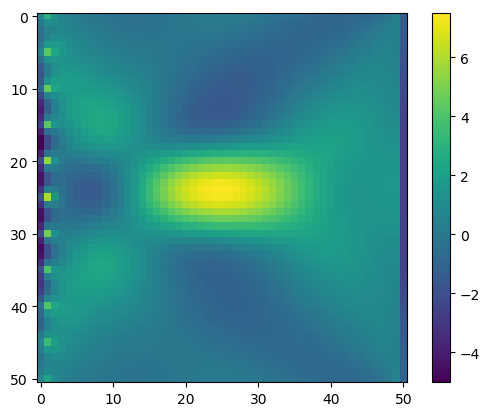

, 105.140519 seconds (2.04 M allocations: 69.204 GiB, 20.90% gc time)


PyObject <matplotlib.colorbar.Colorbar object at 0x1440830b8>

In [142]:
# gg = zeros(Nx, Ny);
# for iter = 1:21
# #     compute gradient
#     gg = gg + grad(a0, iter);
# #     update
# #     a0 = a0 + step_size*gg;
# #     a0 = box_func(a0, 1, 0.8)
#      println("At iteration: ", iter)
# end

@time gg =  compute_grad_all(a0, 11);

imshow(gg); colorbar()

In [134]:
source_index = 5;
d0, u0 = acoustic_solver(a0, b0, Nx, Ny, Nt, dx, dy, dt, source_position, source, receiver_position; pml_len=30, pml_alpha=30, source_index=source_index);

In [135]:
adj_source = d_true[:,:,source_index] - d0;
adj_source = adj_source[end:-1:1,:]
dv, v = acoustic_solver(a0, b0, Nx, Ny, Nt, dx, dy, dt, receiver_position, adj_source, receiver_position; pml_len=30, pml_alpha=30, source_index=0);

In [136]:
    uu = similar(u0)
    uu[:,:,2:end-1] = (u0[:,:,1:end-2] - 2 .* u0[:,:,2:end-1] + u0[:,:,3:end]) ./ dt^2
    uu = uu[:,:,end:-1:1]
    g = v .* uu;
    g = sum(g, dims=3) * dt;
    g = g[:,:,1];

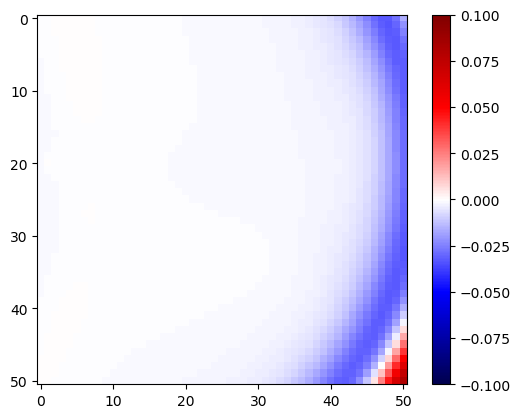

PyObject <matplotlib.colorbar.Colorbar object at 0x13f65c2b0>

In [137]:
amp = 0.1;
imshow(u0[:,:,200], vmin=-amp, vmax=amp, cmap=:seismic); colorbar()

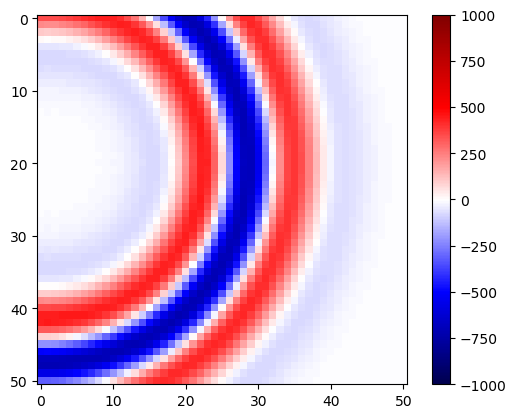

PyObject <matplotlib.colorbar.Colorbar object at 0x13faa7438>

In [138]:
amp = 1000;
imshow(uu[:,:,380], vmin=-amp, vmax=amp, cmap=:seismic); colorbar()

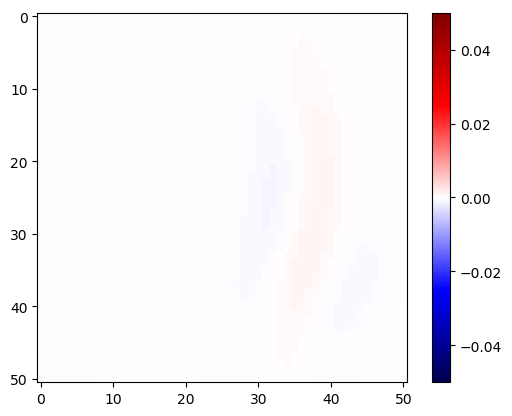

PyObject <matplotlib.colorbar.Colorbar object at 0x1470f8588>

In [139]:
amp = 0.05;
imshow(v[:,:,200], vmin=-amp, vmax=amp, cmap=:seismic); colorbar()

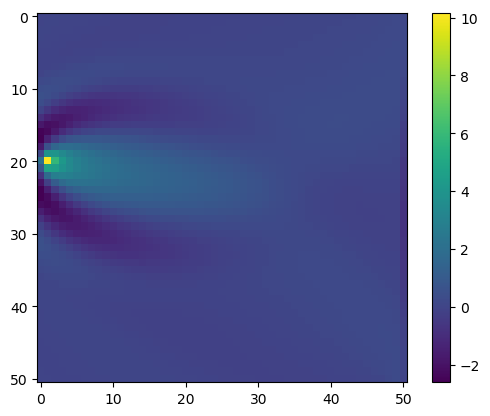

PyObject <matplotlib.colorbar.Colorbar object at 0x1474c4320>

In [140]:
imshow(g); colorbar()

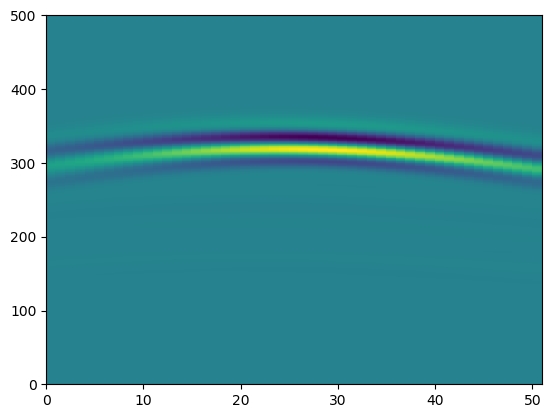

PyObject <matplotlib.collections.PolyCollection object at 0x143558710>

In [133]:
pcolor(adj_source)

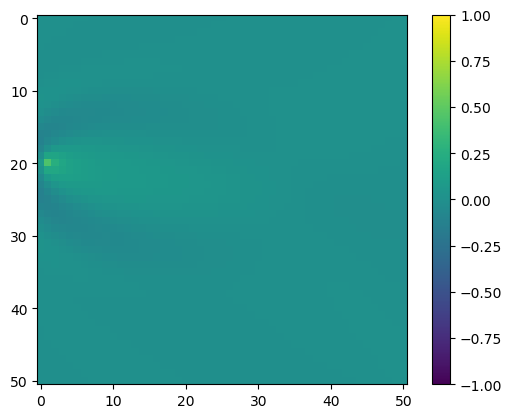

PyObject <matplotlib.colorbar.Colorbar object at 0x148f9ea20>

In [177]:
gg = grad(a0, 5);
imshow(0.05*gg, vmin=-1, vmax=1); colorbar()

In [162]:
minimum(a)

0.6944444444444444

In [181]:
# iterate
step_size = 0.05;
iter_time = 20;
for iter = 1:iter_time
    ind = rand(1:11)
    println("At iteration: ", iter, " random source: ", ind)
#     compute gradient
    gg = grad(a0, ind);
#     update
    a0 = a0 - step_size*gg;
    a0 = box_func(a0, 1, minimum(a))
end

At iteration: 1 random source: 10
At iteration: 2 random source: 8
At iteration: 3 random source: 11
At iteration: 4 random source: 5
At iteration: 5 random source: 5
At iteration: 6 random source: 11
At iteration: 7 random source: 4
At iteration: 8 random source: 4
At iteration: 9 random source: 4
At iteration: 10 random source: 9
At iteration: 11 random source: 1
At iteration: 12 random source: 9
At iteration: 13 random source: 9
At iteration: 14 random source: 10
At iteration: 15 random source: 1
At iteration: 16 random source: 8
At iteration: 17 random source: 7
At iteration: 18 random source: 7
At iteration: 19 random source: 3
At iteration: 20 random source: 4


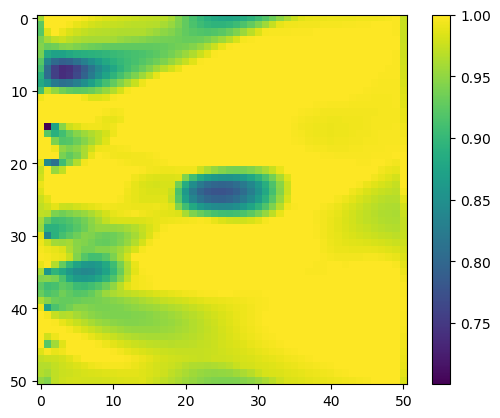

PyObject <matplotlib.colorbar.Colorbar object at 0x14a111320>

In [182]:
imshow(a0); colorbar()

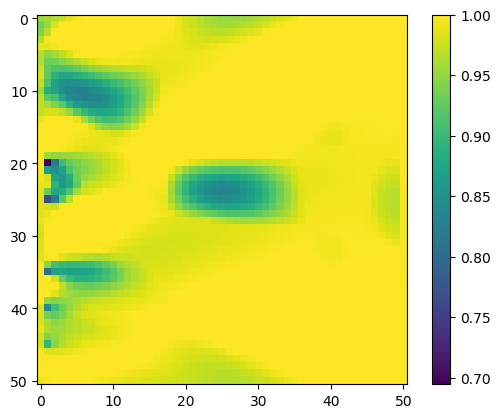

PyObject <matplotlib.colorbar.Colorbar object at 0x148fe7e48>

In [180]:
imshow(a0); colorbar()

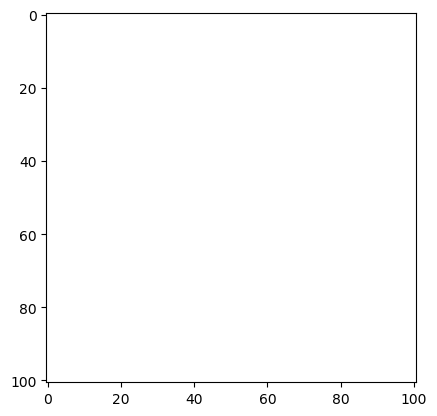

PyObject <matplotlib.image.AxesImage object at 0x17b9b15f8>

In [46]:
gg = grad(a0, ind);
imshow(gg)

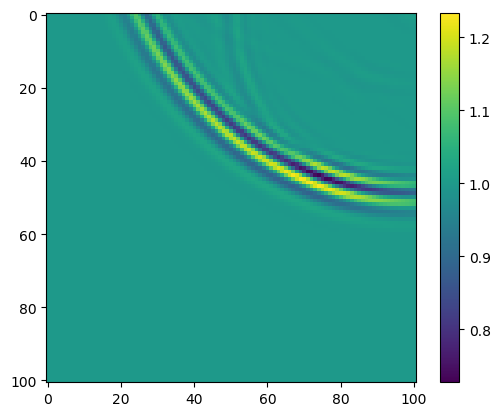

PyObject <matplotlib.colorbar.Colorbar object at 0x17ba32c18>

In [40]:
a0 = a0 - step_size*gg;
imshow(a0); colorbar()

In [27]:
# true solution
# @time d_true, u_true = acoustic_solver(a, b, Nx, Ny, Nt, dx, dy, dt, source_position, source, receiver_position; pml_len=30, pml_alpha=30, source_index=11);
@time d_true, u_true = acoustic_solver_all(a, b, Nx, Ny, Nt, dx, dy, dt, source_position, source, receiver_position; pml_len=30, pml_alpha=30);

InterruptException: InterruptException:

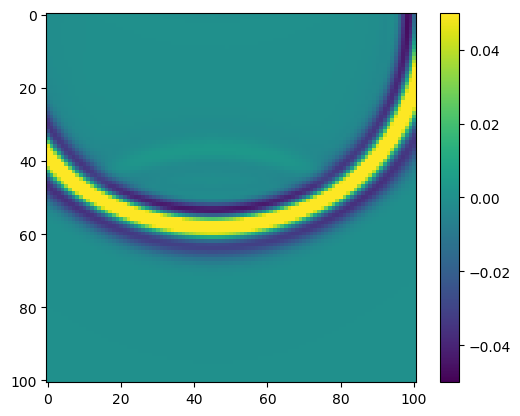

PyObject <matplotlib.colorbar.Colorbar object at 0x13af33860>

In [8]:
# val = maximum.(u_true);
val = 0.05
imshow(u_true[:,:,200,10], vmin=-val, vmax=val); colorbar()

In [ ]:
# ind = rand(1:21)

In [ ]:
# forward problem
@time d0, u0 = acoustic_solver(a0, b0, Nx, Ny, Nt, dx, dy, dt, source_position, source, receiver_position; pml_len=30, pml_alpha=30, source_index=11);

In [ ]:
# adjoint problem
# adj_source = d_true[:,:,ind] - d0;
adj_source = d_true - d0;
@time dv, v = acoustic_solver(a0, b0, Nx, Ny, Nt, dx, dy, dt, receiver_position, adj_source, receiver_position; pml_len=30, pml_alpha=30, source_index=0);

In [ ]:
# Compute gradient
uu = similar(u0)
uu[:,:,2:end-1] = (u0[:,:,1:end-2] - 2 .* u0[:,:,2:end-1] + u0[:,:,3:end]) ./ dt^2
uu = uu[:,:,end:-1:1]
g = v .* uu;
g = sum(g, dims=3) * dt
g = g[:,:,1];

val = maximum(abs.(g))
imshow(g, vmin=-val, vmax=val); colorbar()

In [13]:
ind = rand(1:21);
println("Index: ", ind)
@time gg = compute_grad(d_true, a0, b0, Nx, Ny, Nt, dx, dy, dt, source_position, source, receiver_position, ind);

Index: 7
 19.409847 seconds (383.82 k allocations: 16.326 GiB, 18.63% gc time)


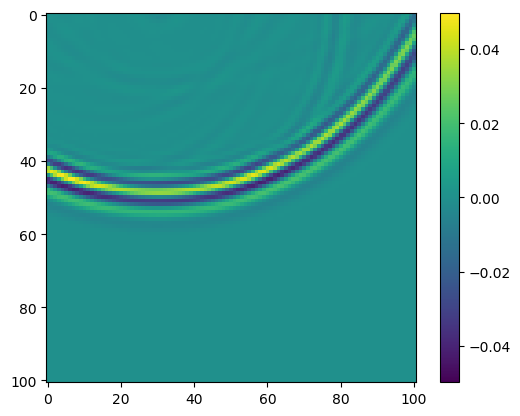

PyObject <matplotlib.colorbar.Colorbar object at 0x17c701470>

In [16]:
val = maximum(abs.(gg))
imshow(gg, vmin=-val, vmax=val); colorbar()

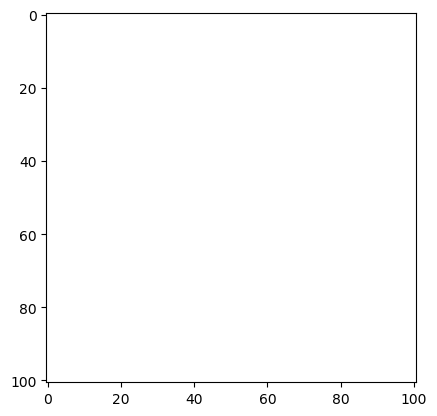

PyObject <matplotlib.image.AxesImage object at 0x17ac486a0>

In [28]:
imshow(a0)

In [58]:
aaa = randn(10,10)

10×10 Array{Float64,2}:
 -0.627655   -1.33144    0.422237  …   0.457306  -0.0436471  -0.715163
  0.49485    -0.630931  -1.10547       0.389565  -1.01798     0.237757
  1.61415     0.581103   0.554986      1.34749   -0.348215   -0.492937
 -1.61154    -1.38931    0.13719      -0.500369  -0.128064    0.92748 
  0.70412     0.86561   -1.83364       0.714623   0.974607    0.276835
 -0.0844623  -2.39922    0.969818  …  -0.869277   0.77816    -0.325493
 -0.785748    0.133553   0.200152      1.16079   -0.383305   -1.16727 
 -1.70437    -0.305388  -0.164874      0.144962  -1.01648    -0.340135
  0.632742   -0.203935  -2.15521       0.670805  -0.92863    -1.7554  
  1.38678     0.122366   0.822489     -0.622044   0.279507    1.30331 

In [63]:
function box_func(A, max_v, min_v)
    A[A.>max_v] .= max_v
    A[A.>max_v] .= max_v
    return A
end

47-element view(::Array{Float64,1}, [2, 3, 5, 9, 10, 13, 15, 17, 20, 21  …  77, 78, 79, 85, 86, 90, 92, 94, 95, 100]) with eltype Float64:
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
  ⋮  
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0

In [64]:
aaa

10×10 Array{Float64,2}:
 -0.627655   -1.33144   10.0       …  10.0       -0.0436471  -0.715163
 10.0        -0.630931  -1.10547      10.0       -1.01798    10.0     
 10.0        10.0       10.0          10.0       -0.348215   -0.492937
 -1.61154    -1.38931   10.0          -0.500369  -0.128064   10.0     
 10.0        10.0       -1.83364      10.0       10.0        10.0     
 -0.0844623  -2.39922   10.0       …  -0.869277  10.0        -0.325493
 -0.785748   10.0       10.0          10.0       -0.383305   -1.16727 
 -1.70437    -0.305388  -0.164874     10.0       -1.01648    -0.340135
 10.0        -0.203935  -2.15521      10.0       -0.92863    -1.7554  
 10.0        10.0       10.0          -0.622044  10.0        10.0     